<a href="https://colab.research.google.com/github/SergeSu111/nba-intelligent-salary/blob/main/nba_salary_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-info">
    <h2>Phase1 Using Machine learning models to predict the NBA Players' salary with on court and off court data</h2>
</div>


<div class="alert alert-block alert-info">
    <h2>Load Data</h2>
</div>


In [116]:
import matplotlib
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
# 用来将分类变量比如球员位置等转换成独热编码 来送入机器学习算法
# standardScaler 用来讲数值特征组标准化. 将数据转换为相同均值 相同标准差来表达同一尺度, 有利于模型稳定
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# 针对不同列应用不同的转换器 比如如果是数值列做standardScaler, 如果是分类特征做OneHotEncoder
from sklearn.compose import ColumnTransformer
# 将预处理数据比如Transformer和最终的模型合在一起形成一个对象. 这样对数据的预处理和模型调用一起搞了
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
# 数据集切分 将原始数据随机划分为训练集和测试集 通常按70/30 80/20比例.
from sklearn.model_selection import train_test_split
# 模型评估指标 MSE 预测值和真实值误差的二次方平均. r^2衡量模型对数据的拟合优度. 越接近1表示模型拟合越好
# MAE 平均绝对误差 预测误差的绝对值平均 对异常值不如MSE敏感
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# 用于填充缺失值NaN
from sklearn.impute import SimpleImputer
from scipy import stats
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, learning_curve
from sklearn.linear_model import HuberRegressor, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network     import MLPRegressor
# Load data from the csvs
stats = pd.read_csv('data/NBA Player Stats(1950 - 2022).csv')
salaries = pd.read_csv('data/NBA Salaries(1990-2023).csv')
from xgboost import XGBRegressor  # pip install xgboost

<div class="alert alert-block alert-info">
    <h2>Data Clean</h2>
</div>


In [70]:

# Clean player names and standardize formatting in both datasets
stats['Player_clean'] = stats['Player'].str.lower().str.strip()
salaries['Player_clean'] = salaries['playerName'].str.lower().str.strip()

# 把赛季字段存放到新的clean列里. 改成int
stats['SeasonYear'] = stats['Season'].astype(int)
salaries['SeasonYear'] = salaries['seasonStartYear'].astype(int)

# Perform a full outer join to merge both datasets on player names and seasons/years
merged_data = pd.merge(
    stats,
    salaries,
    # 指定左表和右表join的特征
    on=['Player_clean', 'SeasonYear'],
    how = "inner",
    suffixes=('_stat','_sal')
)
df = merged_data.loc[:, ~merged_data.columns.str.startswith('Unnamed')]
df['Player_clean'] = df['Player_clean'].fillna(df['Player_clean'])
df.drop(columns=['Player_clean'], inplace=True)
print(df.columns)


# Drop the Unnamed columns since they are just the id columns
df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'Unnamed: 0_x', 'Unnamed: 0_y','playerName','seasonStartYear','inflationAdjSalary'], errors='ignore')

# Columns and their descriptions

# Index: A sequential number assigned to each row, starting from 1.
# Season: The starting year of the NBA season.
# Player: Player's name.
# Pos: Player's position (e.g., G for Guard, F for Forward, C for Center).
# Age: Player's age during the season.
# Tm: Team abbreviation (e.g., LAL for Los Angeles Lakers).
# G: Games played by the player during the season.
# GS: Games started by the player during the season.
# MP: Total minutes played by the player.
# FG: Field goals made (total baskets scored except free throws).
# FGA: Field goals attempted.
# FG%: Field goal percentage (FG / FGA).
# 3P: 3-point shots made.
# 3PA: 3-point shots attempted.
# 3P%: 3-point shooting percentage (3P / 3PA).
# 2P: 2-point shots made.
# 2PA: 2-point shots attempted.
# 2P%: 2-point shooting percentage (2P / 2PA).
# eFG%: Effective field goal percentage, accounting for the added value of 3-pointers.

# FT: Free throws made.
# FTA: Free throws attempted.
# FT%: Free throw percentage (FT / FTA).

# ORB: Offensive rebounds.
# DRB: Defensive rebounds.
# TRB: Total rebounds (ORB + DRB).
# AST: Assists made by the player.
# STL: Steals made by the player.
# BLK: Blocks made by the player.
# TOV: Turnovers (times the player lost possession).
# PF: Personal fouls committed.
# PTS: Total points scored by the player during the season.

# Player_clean: A cleaned version of the Player column (lowercase, stripped of spaces).
# Season_clean: A cleaned version of the Season column.
# playerName: Player's name from the salaries dataset.
# seasonStartYear: Starting year of the NBA season from the salaries dataset.
# salary: Player's salary for the season.
# inflationAdjSalary: Player's salary adjusted for inflation.
# playerName_clean: A cleaned version of the playerName column.

df['salary'] = df['salary'].replace(r'[\$,]', '', regex=True).astype(float)
df.dropna(subset=['Player','SeasonYear','salary'])
print(df)
# 4. 异常值处理（IQR 剔除）
Q1 = df['salary'].quantile(0.25)
Q3 = df['salary'].quantile(0.75)
IQR = Q3 - Q1
df = df[df['salary'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)].copy()

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'SeasonYear', 'playerName', 'seasonStartYear', 'salary',
       'inflationAdjSalary'],
      dtype='object')
       Season         Player Pos   Age   Tm     G    GS      MP     FG  \
0        1990     Mark Acres   C  27.0  ORL  80.0  50.0  1691.0  138.0   
1        1990  Michael Adams  PG  27.0  DEN  79.0  74.0  2690.0  398.0   
2        1990   Mark Aguirre  SF  30.0  DET  78.0  40.0  2005.0  438.0   
3        1990    Danny Ainge  PG  30.0  SAC  75.0  68.0  2727.0  506.0   
4        1990    Mark Alarie  PF  26.0  WSB  82.0  10.0  1893.0  371.0   
...       ...            ...  ..   ...  ...   ...   ...     ...    ...   
13939    2021     Trae Young  PG  22.0  ATL  63.0  63.0  2125.0  487.0   
13940    2021    Cody Zeller   C  28.0  CHO  48.0  21.0  1005.0 

/tmp/ipython-input-70-3785240574.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Player_clean'] = df['Player_clean'].fillna(df['Player_clean'])
/tmp/ipython-input-70-3785240574.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Player_clean'], inplace=True)


In [71]:
df.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'SeasonYear', 'salary'],
      dtype='object')

<div class="alert alert-block alert-info">
    <h2>Feature Engineering</h2>
</div>


In [81]:
# 5.1 计算 Experience（联盟年数）
df['rookie_year'] = df.groupby('Player')['SeasonYear'].transform('min')
df['Experience'] = df['SeasonYear'] - df['rookie_year']

# 5.2 per-game 指标
df['G'] = df['G'].replace(0, np.nan)
# Calculate Points Per Game (PPG)
df['PPG'] = (df['PTS'] / df['G']).fillna(0).round(2)

# Calculate Assists Per Game (APG)
df['APG'] = (df['AST'] / df['G']).fillna(0).round(2)

# Calculate Rebounds Per Game (RPG)
df['RPG'] = (df['TRB'] / df['G']).fillna(0).round(2)

# Calculate Steals Per Game (SPG)
df['SPG'] = (df['STL'] / df['G']).fillna(0).round(2)

# Calculate Blocks Per Game (BPG)
df['BPG'] = (df['BLK'] / df['G']).fillna(0).round(2)

# Calculate Turnovers Per Game (TPG)
df['TPG'] = (df['TOV'] / df['G']).fillna(0).round(2)

# 5.3 自定义综合效率 WEFF
df['WEFF'] = (
    (2*df['PTS'] + 1.5*df['AST'] + 1.2*df['TRB']
     + df['STL'] + df['BLK']
     - 0.5*(df['FGA']-df['FG'])
     - 0.5*(df['FTA']-df['FT'])
     - df['TOV']
    ) / df['G']
).replace([np.inf,-np.inf],0).fillna(0)

# 新增高级特征
df['UsageRate']           = ((df['FGA'] + 0.44*df['FTA'] + df['TOV'])/df['MP']).fillna(0)
df['ShootingEfficiency']  = ((df['FG%'] + df['eFG%'])/2).fillna(0)
df['OffensiveContribution'] = (df['PTS'] + 1.5*df['AST'] + df['ORB']).fillna(0)
df['DefensiveContribution'] = (df['DRB'] + df['STL'] + df['BLK']).fillna(0)
df['GS%']                 = (df['GS']/df['G']).replace([np.inf,-np.inf],0).fillna(0)
df['ImpactScore']         = (df['WEFF']/df['MP']).replace([np.inf,-np.inf],0).fillna(0)
df['MPG']                 = (df['MP']/df['G']).fillna(0)


print(df.columns)

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'SeasonYear', 'salary', 'rookie_year', 'Experience', 'PPG', 'APG',
       'RPG', 'TPG', 'WEFF', 'UsageRate', 'ShootingEfficiency',
       'OffensiveContribution', 'DefensiveContribution', 'GS%', 'ImpactScore',
       'MPG', 'WEFFRange', 'SPG', 'BPG'],
      dtype='object')


<div class="alert alert-block alert-info">
    <h2>Data Visualization</h2>
</div>


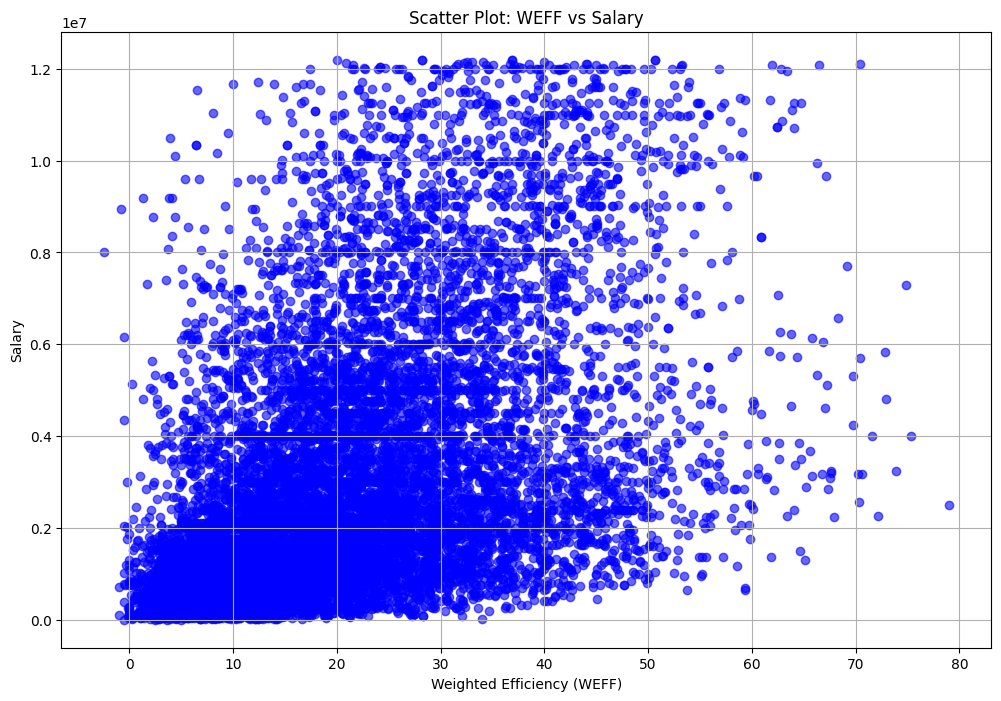

In [82]:
# Scatter Plot: Weighted Efficiency (WEFF) vs Salary
plt.figure(figsize=(12, 8))
plt.scatter(df['WEFF'], df['salary'], alpha=0.6, color='blue')
plt.title('Scatter Plot: WEFF vs Salary')
plt.xlabel('Weighted Efficiency (WEFF)')
plt.ylabel('Salary')
plt.grid(True)
plt.show()


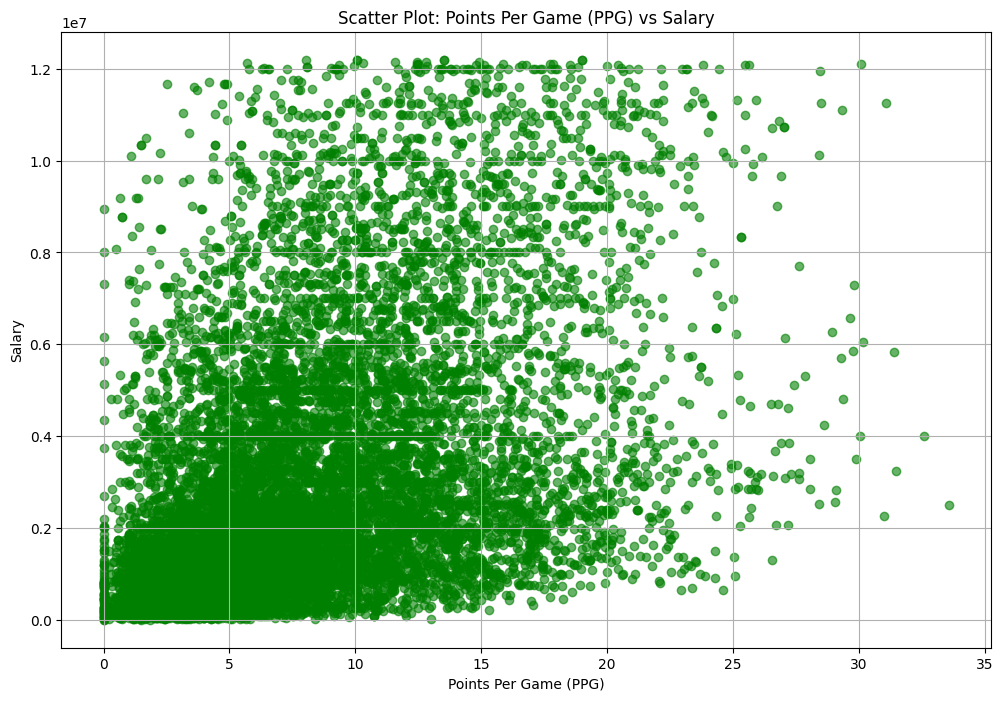

In [83]:
# Scatter Plot: Points Per Game (PPG) vs Salary
df['PPG'] = (df['PTS'] / df['G']).fillna(0).round(2)
plt.figure(figsize=(12, 8))
plt.scatter(df['PPG'], df['salary'], alpha=0.6, color='green')
plt.title('Scatter Plot: Points Per Game (PPG) vs Salary')
plt.xlabel('Points Per Game (PPG)')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

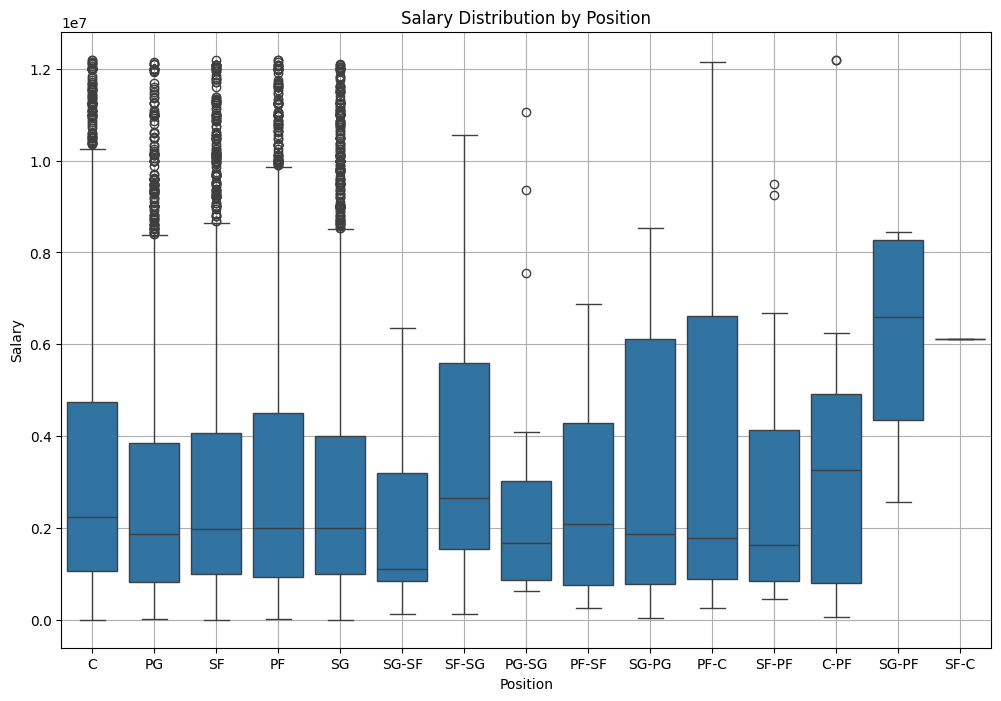

In [84]:
# Box Plot: Salary Distribution by Position
plt.figure(figsize=(12, 8))
sns.boxplot(x='Pos', y='salary', data=df)
plt.title('Salary Distribution by Position')
plt.xlabel('Position')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

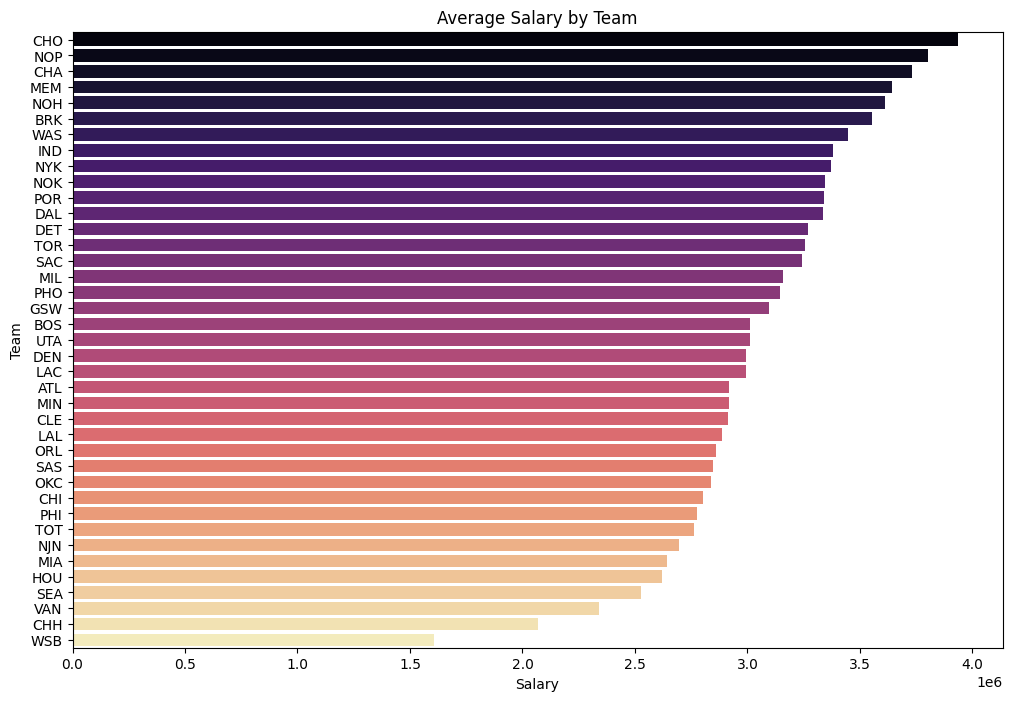

Salary Trends by WEFF Ranges:
  WEFFRange        salary       WEFF  PlayerCount
0        <0  1.533865e+06  -0.318485           33
1      0-10  1.347927e+06   6.393848         2684
2     10-20  2.292680e+06  14.858410         4008
3     20-30  3.615269e+06  24.496718         2980
4     30-40  4.641973e+06  34.432856         1712
5     40-50  5.359653e+06  44.280021          833
6       >50  5.830654e+06  56.677926          312


In [85]:
# Bar Plot: Average Salary by Team
avg_salary_team = df.groupby('Tm')['salary'].mean().reset_index().sort_values('salary', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(y='Tm', x='salary', data=avg_salary_team, hue='Tm', dodge=False, palette='magma')
plt.title('Average Salary by Team')
plt.xlabel('Salary')
plt.ylabel('Team')
plt.show()

#For the scatterplots, there is a trend where players with higher WEFF / PPG generally tend to have higher salaries, though there’s significant variance. But alone, they arent the sole determinants
#So we will use these variables combined with other metrics like WEFF, PPG, RPG, and team to create a multivariate model

# Salary distribution by position highlights which positions tend to earn higher median salaries. Even with variation, certain non-hybrid positions (e.g., PG, C) have more high-salary outliers beyond the third quartile,
#indicating that these roles tend to have elite players earning significantly more than the median.

# Average salary by team shows how different teams have different standards when assigning salaries. So, including Team as a categorical variable in the prediction model can provide valuable information.

# Explore aggregated insights into how salary trends vary by WEFF ranges

# Divide WEFF into meaningful ranges
# 给WEFF 分组.
df['WEFFRange'] = pd.cut(df['WEFF'], bins=[-10, 0, 10, 20, 30, 40, 50, 100],
                         labels=['<0', '0-10', '10-20', '20-30', '30-40', '40-50', '>50'])

# Group data by WEFFRange and calculate aggregated statistics
# 根据weff的区间来判断球员薪水平均值 weff平均值 以及球员数量 最后搞一个df出来.
weff_salary_analysis = df.groupby('WEFFRange', observed=False, as_index=False).agg({'salary': 'mean', 'WEFF': 'mean', 'Player': 'count'})
weff_salary_analysis.rename(columns={'Player': 'PlayerCount'}, inplace=True)
print("Salary Trends by WEFF Ranges:")
print(weff_salary_analysis)


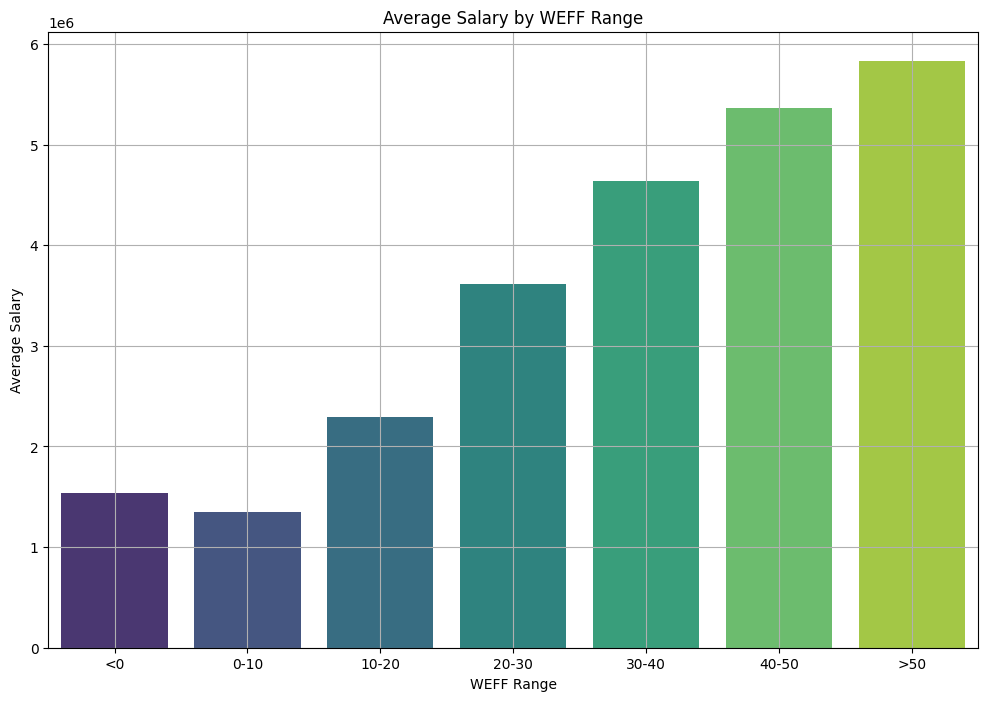

In [86]:
# Visualize Average Salary by WEFF Range
plt.figure(figsize=(12, 8))
sns.barplot(x='WEFFRange', y='salary', hue='WEFFRange', dodge=False, data=weff_salary_analysis, palette='viridis', legend=False)
plt.title('Average Salary by WEFF Range')
plt.xlabel('WEFF Range')
plt.ylabel('Average Salary')
plt.grid(True)
plt.show()

In [89]:

# - The visualization shows that as WEFF (Weighted Efficiency) increases, the average salary also increases significantly.
# - Players with WEFF in the highest range (>50) earn the highest average salary (~$12 million), confirming that elite performance levels are highly valued in terms of salary.
# - Most players fall within the 0-10 and 10-20 WEFF ranges, indicating that mid-range efficiency is the norm for most players.
# - The visualization highlights how salary progressively scales with WEFF, with noticeable jumps between ranges, especially in the higher efficiency ranges (30-40, 40-50, >50).

# - This means categorizing WEFF into ranges can provide additional insights into player value and performance tiers

df.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'SeasonYear', 'salary', 'rookie_year', 'Experience', 'PPG', 'APG',
       'RPG', 'TPG', 'WEFF', 'UsageRate', 'ShootingEfficiency',
       'OffensiveContribution', 'DefensiveContribution', 'GS%', 'ImpactScore',
       'MPG', 'WEFFRange', 'SPG', 'BPG'],
      dtype='object')

<div class="alert alert-block alert-info">
    <h2>OLS</h2>
</div>


                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     262.1
Date:                Sat, 12 Jul 2025   Prob (F-statistic):               0.00
Time:                        01:02:42   Log-Likelihood:                -12405.
No. Observations:               10049   AIC:                         2.488e+04
Df Residuals:                   10016   BIC:                         2.511e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.52

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                  feature          VIF
1                     PTS          inf
2                     AST          inf
4                     STL          inf
3                     TRB          inf
5                     BLK          inf
7                     FGA          inf
33                    2PA          inf
8                      FG          inf
10                     FT          inf
37                     2P          inf
36                    DRB          inf
31                    3PA          inf
24  DefensiveContribution          inf
23  OffensiveContribution          inf
30                    ORB          inf
14                   WEFF  7310.163089
15                    PPG  4172.345531
17                    RPG   365.900584
16                    APG   330.085533
0                   const   260.263070
9                     FTA   126.692797
20                    TPG    58.468640
6                     TOV    50.254060
13                     MP    48.845631
12                     GS

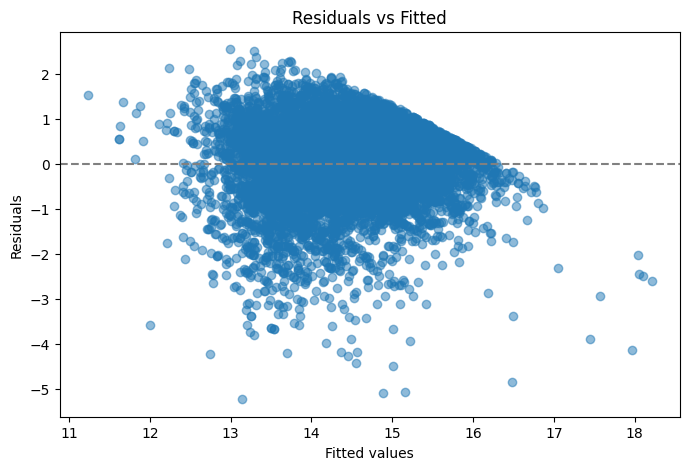

In [108]:
# INITIAL MODEL:

# Select relevant features for salary prediction
# The features below include both raw metrics and engineered features
features = [
    'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'FGA', 'FG', 'FTA', 'FT',
    'G', 'GS', 'MP', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG',
    'UsageRate', 'ShootingEfficiency', 'OffensiveContribution', 'DefensiveContribution',
    'Age', 'Experience', 'GS%', 'ImpactScore', 'Pos', 'PF', 'ORB', '3PA', '3P%',
    '2PA', '2P%', 'FT%', 'DRB', '2P'
]

target = 'salary'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. 诊断：初步 OLS 回归
numeric_feats = [f for f in features if df[f].dtype in [np.int64, np.float64]]
# 拷贝训练集的这些列
X0 = X_train[numeric_feats].copy()

# 1) 把 inf 替换成 NaN
X0.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2) 对 NaN 做中位数填补（也可以选择 dropna）
X0.fillna(X0.median(), inplace=True)

# 3) 加上截距项
X0 = sm.add_constant(X0)

# 同样确保 y0 和 X0 对齐，并做 log1p 变换
y0 = pd.Series(np.log1p(y_train), index=y_train.index)
y0 = y0.loc[X0.index]

ols = sm.OLS(y0, X0).fit()
print(ols.summary())

# 异方差检验
bp_test = het_breuschpagan(ols.resid, ols.model.exog)
print("Breusch-Pagan test:", bp_test)

# 残差正态性检验
norm_test = normal_ad(ols.resid)
print("Normal AD test:", norm_test)

# 多重共线性（VIF）
vif_data = pd.DataFrame({
    'feature': X0.columns,
    'VIF': [variance_inflation_factor(X0.values, i)
            for i in range(X0.shape[1])]
})
print(vif_data.sort_values('VIF', ascending=False))

# 残差 vs 拟合值可视化
resid = ols.resid
fitted = ols.fittedvalues
plt.figure(figsize=(8,5))
plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


<div class="alert alert-block alert-info">
    <h2>After Diagonose from OLS Random Forest is the best</h2>
</div>


In [117]:
reduced_features = [
    # 高级指标
    'UsageRate', 'ShootingEfficiency', 'ImpactScore',
    # 基础控制
    'Experience', 'Age','2P%','FT%','3P%',
    # 分类
    'Pos', 'Tm'
]

X = df[reduced_features]
y = df['salary']

# 12.2 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 12.3 重用之前的预处理
numeric_feats_reduced = [f for f in reduced_features if f not in ['Pos','Tm']]
categorical_feats_reduced = ['Pos','Tm']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats_reduced),
    ('cat', categorical_transformer, categorical_feats_reduced)
])

# 12.4 定义多种模型 Pipeline
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Linear': Pipeline([
        ('pre', preprocessor),
         ('reg', LinearRegression())
    ]),
    'Huber': Pipeline([
        ('pre', preprocessor),
        ('reg', HuberRegressor())
    ]),
    'Ridge': Pipeline([
        ('pre', preprocessor),
        ('reg', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=tscv))
    ]),
    'ElasticNet': Pipeline([
        ('pre', preprocessor),
        ('reg', ElasticNetCV(l1_ratio=[0.1,0.5,0.9], cv=tscv, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    'SVR': Pipeline([('pre', preprocessor),('reg', SVR(kernel='rbf'))]),
    'DecisionTree':Pipeline([('pre', preprocessor), ('reg', DecisionTreeRegressor(random_state=42))]),
    'XGBoost': Pipeline([('pre', preprocessor),('reg', XGBRegressor(n_estimators=100,random_state=42))]),

}

# 12.5 交叉验证比较各模型 MAE
print("Cross-validated MAE (TimeSeriesSplit):")
for name, pipe in models.items():
    scores = -cross_val_score(pipe, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    print(f"{name:12s}: MAE = {scores.mean():.0f} ± {scores.std():.0f}")

Model          MAE     Std
---------------------------------
Linear         1917235  ±208620
Huber          1952381  ±196252
Ridge          1915731  ±208653
ElasticNet     2215803  ±227569


KeyboardInterrupt: 

<div class="alert alert-block alert-info">
# **   <h2>small ranged RandomizedSearchCV + test set evaluations 可删 因为后面又evalue_models function</h2>**
</div>


In [119]:
tscv = TimeSeriesSplit(n_splits=3)    # 折数可调
results = []

# 1. 定义模型与它们的小范围超参空间
model_param = {
    'Linear': {
        'pipe': Pipeline([('pre', preprocessor),('reg', LinearRegression())]),
        'params': {}  # 线性回归默认即可
    },
    'Ridge': {
        'pipe': Pipeline([('pre', preprocessor),('reg', RidgeCV(alphas=[0.1,1,10], cv=tscv))]),
        'params': {}
    },
    'SVR': {
        'pipe': Pipeline([('pre', preprocessor),('reg', SVR())]),
        'params': {
            'reg__kernel': ['rbf','linear'],
            'reg__C': [0.1,1,10],
            'reg__gamma': ['scale','auto']
        }
    },
    'MLP': {
        'pipe': Pipeline([('pre', preprocessor),('reg', MLPRegressor(max_iter=2000, random_state=42))]),
        'params': {
            'reg__hidden_layer_sizes': [(50,),(50,50)],
            'reg__alpha': [1e-4,1e-3],
            'reg__learning_rate_init': [1e-3,1e-2]
        }
    },
    'DecisionTree': {
        'pipe': Pipeline([('pre', preprocessor),('reg', DecisionTreeRegressor(random_state=42))]),
        'params': {
            'reg__max_depth': [None,10,20],
            'reg__min_samples_leaf': [1,2,4]
        }
    },
    'RandomForest': {
        'pipe': Pipeline([('pre', preprocessor),('reg', RandomForestRegressor(random_state=42))]),
        'params': {
            'reg__n_estimators': [100,200],
            'reg__max_depth': [None,10,20],
            'reg__max_features': ['sqrt','log2']
        }
    },
    'XGBoost': {
        'pipe': Pipeline([('pre', preprocessor),('reg', XGBRegressor(random_state=42))]),
        'params': {
            'reg__n_estimators': [100,200],
            'reg__max_depth': [3,6],
            'reg__learning_rate': [0.01,0.1]
        }
    },
}

# 2. 循环调参 & 评估
for name, mp in model_param.items():
    pipe = mp['pipe']
    params = mp['params']

    if params:
        search = RandomizedSearchCV(
            pipe, params, n_iter=5,
            cv=tscv, scoring='neg_mean_absolute_error',
            random_state=42, n_jobs=-1
        )
    else:
        # 如果没有超参，就直接 fit
        search = pipe

    # 拆分并训练
    search.fit(X_train, y_train)
    best = search.best_estimator_ if params else search

    # 测试集评估
    y_pred = best.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)

    results.append({
        'model': name,
        'best_params': search.best_params_ if params else None,
        'MAE': mae, 'RMSE': rmse, 'R2': r2
    })

# 3. 汇总结果
import pandas as pd
df_results = pd.DataFrame(results).set_index('model')
print(df_results.sort_values('MAE'))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


                                                    best_params           MAE  \
model                                                                           
XGBoost       {'reg__n_estimators': 200, 'reg__max_depth': 6...  1.235564e+06   
RandomForest  {'reg__n_estimators': 100, 'reg__max_features'...  1.323969e+06   
MLP           {'reg__learning_rate_init': 0.01, 'reg__hidden...  1.326070e+06   
DecisionTree  {'reg__min_samples_leaf': 4, 'reg__max_depth':...  1.437493e+06   
Ridge                                                      None  1.796490e+06   
Linear                                                     None  1.798096e+06   
SVR           {'reg__kernel': 'linear', 'reg__gamma': 'scale...  2.003384e+06   

                      RMSE        R2  
model                                 
XGBoost       1.712011e+06  0.629713  
RandomForest  1.794891e+06  0.592993  
MLP           1.838701e+06  0.572882  
DecisionTree  2.054180e+06  0.466907  
Ridge         2.407299e+06  0.267874

In [123]:
from sklearn.model_selection    import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics            import mean_absolute_error, mean_squared_error, r2_score

tscv = TimeSeriesSplit(n_splits=3)

def evaluate_models(X_train, X_test, y_train, y_test, model_param):
    """对给定的模型字典做小范围调参并评估，返回 best_params 和测试集指标。"""
    results = []
    for name, mp in model_param.items():
        pipe   = mp['pipe']
        params = mp['params']
        if params:
            search = RandomizedSearchCV(
                pipe, params, n_iter=5,
                cv=tscv, scoring='neg_mean_absolute_error',
                random_state=42, n_jobs=-1
            )
        else:
            search = pipe
        search.fit(X_train, y_train)
        best = search.best_estimator_ if params else search

        y_pred = best.predict(X_test)
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        r2   = r2_score(y_test, y_pred)

        results.append({
            'model':      name,
            'best_params': getattr(search, 'best_params_', None),
            'MAE':         mae,
            'RMSE':        rmse,
            'R2':          r2
        })
    return results

# 1. 定义模型与它们的小范围超参空间
model_param = {
    'Linear': {
        'pipe': Pipeline([('pre', preprocessor),('reg', LinearRegression())]),
        'params': {}  # 线性回归默认即可
    },
    'Ridge': {
        'pipe': Pipeline([('pre', preprocessor),('reg', RidgeCV(alphas=[0.1,1,10], cv=tscv))]),
        'params': {}
    },
    'SVR': {
        'pipe': Pipeline([('pre', preprocessor),('reg', SVR())]),
        'params': {
            'reg__kernel': ['rbf','linear'],
            'reg__C': [0.1,1,10],
            'reg__gamma': ['scale','auto']
        }
    },
    'MLP': {
        'pipe': Pipeline([('pre', preprocessor),('reg', MLPRegressor(max_iter=2000, random_state=42))]),
        'params': {
            'reg__hidden_layer_sizes': [(50,),(50,50)],
            'reg__alpha': [1e-4,1e-3],
            'reg__learning_rate_init': [1e-3,1e-2]
        }
    },
    'DecisionTree': {
        'pipe': Pipeline([('pre', preprocessor),('reg', DecisionTreeRegressor(random_state=42))]),
        'params': {
            'reg__max_depth': [None,10,20],
            'reg__min_samples_leaf': [1,2,4]
        }
    },
    'RandomForest': {
        'pipe': Pipeline([('pre', preprocessor),('reg', RandomForestRegressor(random_state=42))]),
        'params': {
            'reg__n_estimators': [100,200],
            'reg__max_depth': [None,10,20],
            'reg__max_features': ['sqrt','log2']
        }
    },
    'XGBoost': {
        'pipe': Pipeline([('pre', preprocessor),('reg', XGBRegressor(random_state=42))]),
        'params': {
            'reg__n_estimators': [100,200],
            'reg__max_depth': [3,6],
            'reg__learning_rate': [0.01,0.1]
        }
    },
}

# 2. 外层循环：给定多组 features
feature_sets = [
    reduced_features,                        # 第一组场上核心特征
    # reduced_features + extra_offcourt_feats, # 第二组，加点场下
    # …你还可以加第三组、第四组
]

all_results = []
for feats in feature_sets:
    X = df[feats]; y = df['salary']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


    # —— 2. 根据 feats 动态构造 preprocessor ——
    numeric_feats   = [c for c in feats if df[c].dtype in ['int64','float64']]
    categorical_feats = [c for c in feats if df[c].dtype == 'object']

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_feats),
        ('cat', categorical_transformer, categorical_feats)
    ])

    # —— 3. 对每个模型，构建带新 preprocessor 的 Pipeline，并做小范围调参 + 测试评估 ——
    for name, mp in model_param.items():
      base_pipe = mp['pipe']  # 这是之前写好的 Pipeline
      # 从中拿出 reg 这一步的 estimator
      est = base_pipe.named_steps['reg']
      # 然后用新的 preprocessor + 这个 est 组装
      pipe = Pipeline([('pre', preprocessor), ('reg', est)])
      params = mp['params']

      if mp['params']:
        search = RandomizedSearchCV(
                pipe,
                mp['params'],
                n_iter=5,
                cv=tscv,
                scoring='neg_mean_absolute_error',
                random_state=42,
                n_jobs=-1
            )
      else:
          search = pipe

      search.fit(X_train, y_train)
      best = search.best_estimator_ if mp['params'] else search

      y_pred = best.predict(X_test)
      mae  = mean_absolute_error(y_test, y_pred)
      rmse = mean_squared_error(y_test, y_pred)**0.5
      r2   = r2_score(y_test, y_pred)

      all_results.append({
          'featureset': feats,
          'model':      name,
          'best_params': getattr(search, 'best_params_', {}),
          'MAE':         mae,
          'RMSE':        rmse,
          'R2':          r2
      })

# 3. 最后把 all_results 汇总到 DataFrame
import pandas as pd
df_all = pd.DataFrame(all_results)
print(df_all[['featureset','model','MAE','RMSE','R2','best_params']])


KeyboardInterrupt: 

<div class="alert alert-block alert-info">
    <h2>Visualize the realtionship between numerical features and salary to get ride of some features</h2>
</div>


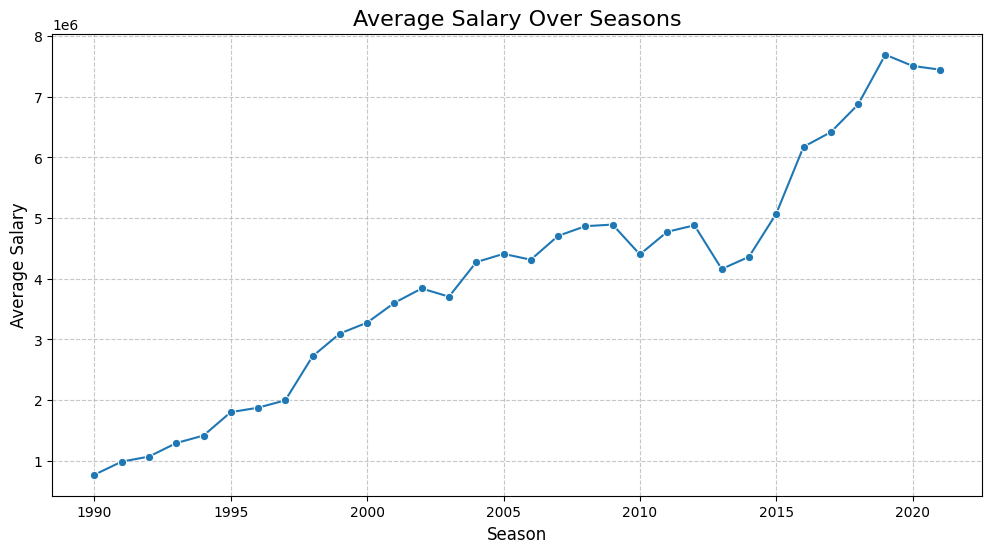

In [19]:
# Create more visualizations to find meaningful features and patterns for predicting salary
# Average Salary Over Time
# 对薪资随时间变化的关系.  按照赛季分组. 得到每个赛季的平均薪水
avg_salary_by_season = df.groupby('Season')['salary'].mean()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_salary_by_season.index, y=avg_salary_by_season.values, marker='o')
plt.title('Average Salary Over Seasons', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# This plot shows the trend of average NBA player salaries over seasons.
# - Salaries steadily increased from 1990 to 2015, reflecting the NBA's growing revenue and popularity.
# - Around 2014, there was a period of stagnation in salary growth, likely due to the salary cap constraints before the massive TV rights deal signed in 2014 (effective in 2016).
# - A sharp spike in 2016 corresponds to the new TV rights deal, which significantly increased the salary cap.
# - Post-2020, salaries show slight stagnation or decline, likely influenced by the financial impacts of the COVID-19 pandemic.
# This highlights how external factors, such as league revenue and salary cap adjustments, directly impact player salaries.
# So, season is important factor in predicting salary

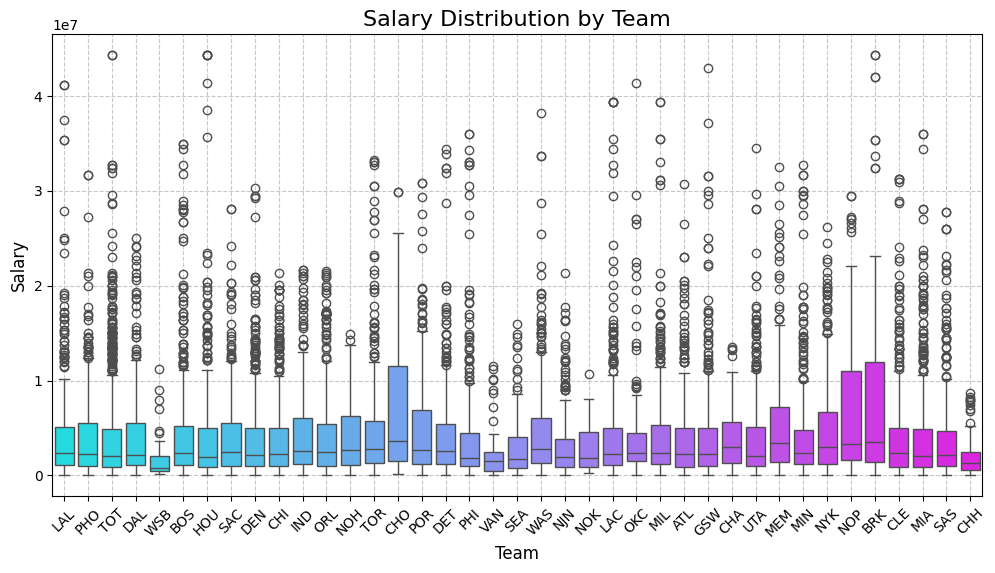

In [20]:
# Box Plot: Salary by Team # 这里又开始对Team和Salary之间的关系做可视化
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Tm', y='salary', palette='cool', hue='Tm')
plt.title('Salary Distribution by Team', fontsize=16)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Salary', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

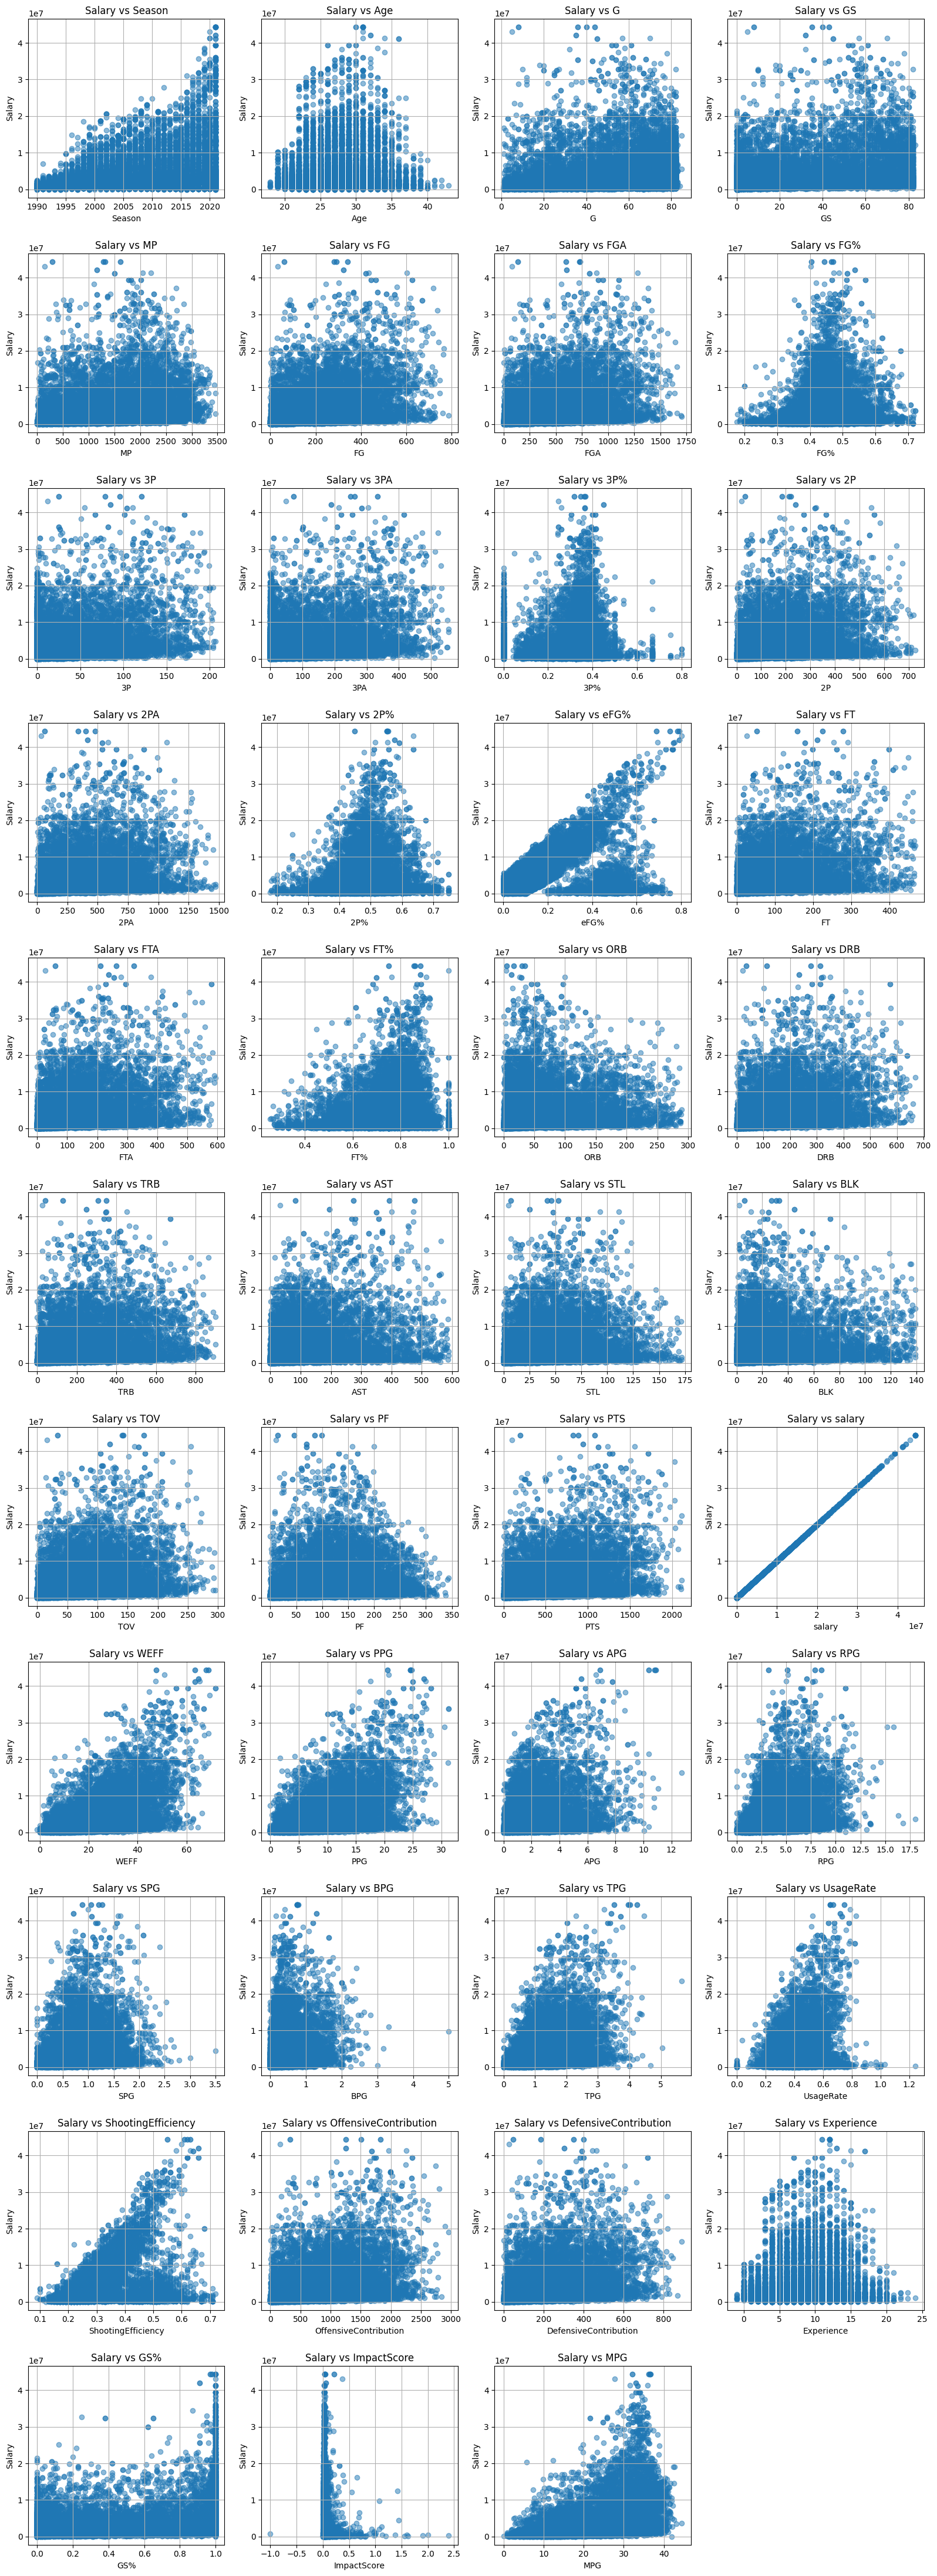

In [21]:
# This visualization helps by showing the salary distribution across different teams, highlighting variations in team spending habits.
# It reveals which teams have more consistent salary structures versus those with large disparities, likely due to a few superstar contracts.
# This insight emphasizes the importance of including the team (Tm) as a feature in the salary prediction model, as team-level factors significantly influence player salaries.

# For example, BRK (Brooklyn Nets) shows large disparities in salary distribution, with a wide IQR, indicating significant salary for superstar players.

#Scatterplots for all the metrics vs salary --> show the plots again
# 将每一个数值特征拿过来和薪水做可视化 看看哪些特征高度相关哪些特征不相关可以删除

int_columns = ['Season', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
 'salary', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
 'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%', 'ImpactScore', 'MPG']

plots_per_row = 4
total_plots = len(int_columns)
rows = (total_plots // plots_per_row) + (total_plots % plots_per_row > 0)

fig, axes = plt.subplots(rows, plots_per_row, figsize=(16, rows * 4))
axes = axes.flatten()

for idx, column in enumerate(int_columns):
    axes[idx].scatter(df[column], df['salary'], alpha=0.5)
    axes[idx].set_title(f'Salary vs {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Salary')
    axes[idx].grid(True)
for ax in axes[total_plots:]:
    ax.axis('off')
plt.tight_layout()
plt.show()


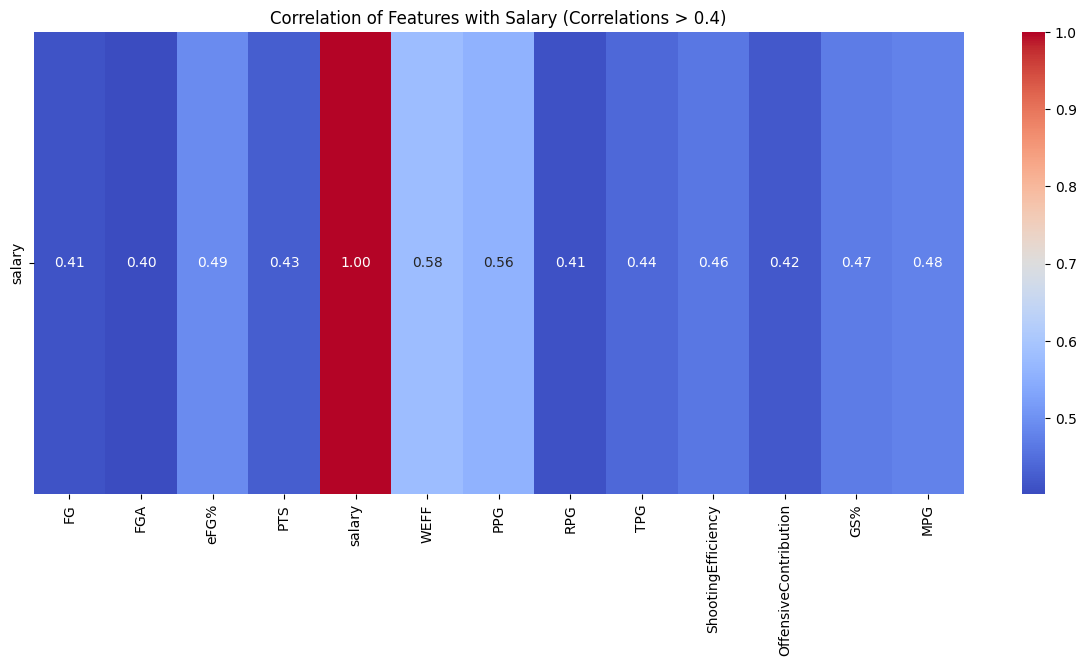

In [22]:
#heatmap that visually represents the correlation between the important selected features from above and salary
# 热力图使用颜色深浅来直观表示数值大小或强弱关系的二位图标. 如果颜色很深则表示数值之间高度相关 可能会有共线性.
# 也可以看出来哪些特征对于目标变量很关键 或不关键

columns_of_interest = ['Season', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
                       'salary', 'WEFF', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TPG', 'UsageRate', 'ShootingEfficiency',
                       'OffensiveContribution', 'DefensiveContribution', 'Experience', 'GS%', 'ImpactScore', 'MPG']

correlation_matrix = df[columns_of_interest].corr()

# Find correlations greater than 0.4 of features with salary
salary_correlation = correlation_matrix['salary'][correlation_matrix['salary'] > 0.4]

salary_correlation_df = salary_correlation.to_frame().T

# Plot the heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(salary_correlation_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of Features with Salary (Correlations > 0.4)")
plt.show()

# We see these features have relatively useful correlation with salary: 'GS', 'FG', 'FGA', 'eFG%', 'DRB', 'PTS', 'WEFF', 'PPG', 'RPG', 'TPG', 'ShootingEfficiency', 'OffensiveContribution','DefensiveContribution', 'GS%', 'MPG'
# This relates to the plots we did before too ; so we will include these in overall model

<div class="alert alert-block alert-info">
    <h2>Second Time Linear Regression</h2>
</div>


In [23]:
# Define the target variable and features (the ones we found were good from the plots, correlation, and sql queries)
# 重新做一次linear regression 这次挑出了一些最具有价值的特征做回归. 跳出了最强的17个特征
selected_columns = [
    'Season', 'Tm', 'Age', 'GS', 'FG', 'FGA', 'eFG%',
    'WEFF', 'PPG', 'RPG', 'TPG', 'APG',
    'ShootingEfficiency', 'OffensiveContribution',
    'DefensiveContribution', 'GS%', 'MPG'
]
X = df[selected_columns]  # Use only the specified columns for features
y = df['salary']  # Use Salary as the target

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
#
# Define transformations for each column type
# 重新再做一次onehot 因为之前第一次做linear regression虽然也做了 但只是临时的
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical columns
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#linear Regression Model


# Create a pipeline with Linear Regression
linear_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
linear_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = linear_reg_pipeline.predict(X_test)

# Evaluation
print("Linear Regression Results")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))



Linear Regression Results
Mean Absolute Error (MAE): 2452572.8633901807
Mean Squared Error (MSE): 11312995013889.516
R² score: 0.643007126585607
